In [1]:
import os,sys
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
import matplotlib as plt
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

In [2]:
### Enter the data folder name and WCR information

# select fold
fold_idx = 1

# Load the data folder path
path = os.getcwd()
train_path_upper = path + f'/data_mortar/FOLD_{fold_idx}/train'
valid_path_upper = path + f'/data_mortar/FOLD_{fold_idx}/valid'
test_path_upper = path + f'/data_mortar/FOLD_{fold_idx}/test'

# Set the name of the training model file to save.
model_save_name = "WCRnet.h5"

# WCR information
WC_name_tag = [40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60]

# Fit the random seed
seed_data = 4885
random.seed(seed_data)
np.random.seed(seed_data)
os.environ["PYTHONHASHSEED"] = str(seed_data)
tf.random.set_seed(seed_data)

model_save_dir = path + f'/save_models/{model_save_name}'

# Layer paramter for WCRnet
layer_list = [3, 4, 6, 3]

# Parameter for Training
epochs = 1000                 # training epochs
batch_sizes = 1024            # batch size
initial_learning_rate = 0.01   # initial learning rate
input_shape = 6               # input shape of the model

In [3]:
### Data normalization

# Normalize to the minimum and maximum sensor measurement values.
def sense_min_max_Normalization(input_data, min_value, max_value):
    data = (input_data - min_value) / (max_value - min_value) 
    
    return data

def data_set_normalization(data):
    # sensor_min_value
    vwc_min = 0
    ec_min = 0
    salinity_min = 0
    tds_min = 0
    epsilon_min = 0
    temp_min = -40
    
    # sensor_max_value
    vwc_max = 100
    ec_max = 20000
    salinity_max = 20000
    tds_max = 20000
    temp_max = 80
    epsilon_max = 82
    
    # sensor_normalization 
    data['TEMP'] = sense_min_max_Normalization(data['TEMP'],temp_min,temp_max)
    data['EC'] = sense_min_max_Normalization(data['EC'],ec_min,ec_max)
    data['VWC'] = sense_min_max_Normalization(data['VWC'],vwc_min,vwc_max)
    data['TDS'] = sense_min_max_Normalization(data['TDS'],tds_min,tds_max)
    data['SALINITY'] = sense_min_max_Normalization(data['SALINITY'],salinity_min,salinity_max)
    data['EPSILON'] = sense_min_max_Normalization(data['EPSILON'],epsilon_min,epsilon_max)
    
    return data

In [4]:
### Load FDR Data for Train

path_list = []
path_under=os.listdir(train_path_upper)

# load data_path
for i in range(len(path_under)): # collect under directory file path
    path_sub=os.listdir(train_path_upper+'/'+path_under[i])
    
    for j in range(len(path_sub)):
        path_list.append(train_path_upper+'/'+path_under[i]+'/'+path_sub[j])

# make zero matrix
data_list = [0]*len(path_list)
rand_x_data_list = [0]*len(path_list)
rand_y_data_list = [0]*len(path_list)

# load data_value
for i,j in enumerate(path_list):
    data_list[i] =pd.read_csv(j)
    data_list[i] = data_set_normalization(data_list[i])
    
train_data = pd.concat(data_list)

# Print the data format
train_data

,WC_ratio,TEMP,EC,VWC,TDS,SALINITY,EPSILON
0,0.4,0.514917,0.19240,0.6391,0.09620,0.10580,0.720488
1,0.4,0.514417,0.19580,0.6512,0.09790,0.10765,0.736098
2,0.4,0.514417,0.19600,0.6549,0.09800,0.10780,0.740610
3,0.4,0.514250,0.19630,0.6568,0.09815,0.10795,0.742927
4,0.4,0.513833,0.19660,0.6587,0.09830,0.10810,0.745244
...,...,...,...,...,...,...,...
468,0.6,0.495333,0.28745,0.9264,0.14370,0.15805,0.955366
469,0.6,0.495333,0.28750,0.9374,0.14375,0.15810,0.961341
470,0.6,0.495333,0.28795,0.9320,0.14395,0.15835,0.958415
471,0.6,0.495333,0.28795,0.9320,0.14395,0.15835,0.958415


In [5]:
### Load FDR Data for Valid

valid_path_list = []
valid_path_under=os.listdir(valid_path_upper)

# load data_path
for i in range(len(valid_path_under)): # collect under directory file path
    valid_path_sub=os.listdir(valid_path_upper+'/'+valid_path_under[i])
    
    for j in range(len(valid_path_sub)):
        valid_path_list.append(valid_path_upper+'/'+valid_path_under[i]+'/'+valid_path_sub[j])

# make zero matrix
valid_data_list = [0]*len(valid_path_list)
valid_rand_x_data_list = [0]*len(valid_path_list)
valid_rand_y_data_list = [0]*len(valid_path_list)

# load data_value
for i,j in enumerate(valid_path_list):
    valid_data_list[i] =pd.read_csv(j)
    valid_data_list[i] = data_set_normalization(valid_data_list[i])
    
valid_data = pd.concat(valid_data_list)

# Print the data format
valid_data

,WC_ratio,TEMP,EC,VWC,TDS,SALINITY,EPSILON
0,0.4,0.491083,0.18165,0.6014,0.09080,0.09990,0.665610
1,0.4,0.491083,0.18250,0.6014,0.09125,0.10035,0.665610
2,0.4,0.490833,0.18360,0.6052,0.09180,0.10095,0.671707
3,0.4,0.490833,0.18405,0.6052,0.09200,0.10120,0.671707
4,0.4,0.490583,0.18455,0.6092,0.09225,0.10150,0.677927
...,...,...,...,...,...,...,...
455,0.6,0.492417,0.28650,0.9488,0.14325,0.15755,0.967439
456,0.6,0.492667,0.28650,0.9488,0.14325,0.15755,0.967439
457,0.6,0.492667,0.28650,0.9488,0.14325,0.15755,0.967439
458,0.6,0.492417,0.28655,0.9488,0.14325,0.15760,0.967439


In [6]:
### Load FDR Data for Test

test_path_list = []
test_path_under=os.listdir(test_path_upper)

# load data_path
for i in range(len(test_path_under)): # collect under directory file path
    test_path_sub=os.listdir(test_path_upper+'/'+test_path_under[i])
    
    for j in range(len(test_path_sub)):
        test_path_list.append(test_path_upper+'/'+test_path_under[i]+'/'+test_path_sub[j])

# make zero matrix
test_data_list = [0]*len(test_path_list)
test_rand_x_data_list = [0]*len(test_path_list)
test_rand_y_data_list = [0]*len(test_path_list)

# load data_value
for i,j in enumerate(test_path_list):
    test_data_list[i] =pd.read_csv(j)
    test_data_list[i] = data_set_normalization(test_data_list[i])
    
test_data = pd.concat(test_data_list)

# Print the data format
test_data

,WC_ratio,TEMP,EC,VWC,TDS,SALINITY,EPSILON
0,0.4,0.491500,0.15550,0.5570,0.07775,0.08550,0.585610
1,0.4,0.491500,0.15625,0.5588,0.07810,0.08590,0.589146
2,0.4,0.491083,0.15690,0.5597,0.07845,0.08625,0.590976
3,0.4,0.490833,0.15750,0.5597,0.07875,0.08660,0.590976
4,0.4,0.490833,0.15805,0.5597,0.07900,0.08690,0.590976
...,...,...,...,...,...,...,...
513,0.6,0.487667,0.29310,0.9488,0.14655,0.16120,0.967439
514,0.6,0.487667,0.29355,0.9488,0.14675,0.16145,0.967439
515,0.6,0.487667,0.29400,0.9488,0.14700,0.16170,0.967439
516,0.6,0.487667,0.29355,0.9488,0.14675,0.16145,0.967439


In [7]:
# GT-label for Train (WCR)
y_R = round(train_data['WC_ratio']*100, 1)
y_train = y_R.to_numpy()

# FDR sensor data for Train
x_R = train_data[['TEMP','VWC','EPSILON','SALINITY','TDS','EC']]
x_train = x_R.to_numpy()

x_train_shuffled, y_train_shuffled = shuffle(x_train, y_train, random_state=seed_data)

In [8]:
# GT-label for Valid (WCR)
y_R_valid = round(valid_data['WC_ratio']*100, 1)
y_valid = y_R_valid.to_numpy()

# FDR sensor data for Valid
x_R_valid = valid_data[['TEMP','VWC','EPSILON','SALINITY','TDS','EC']]
x_valid = x_R_valid.to_numpy()

x_valid_shuffled, y_valid_shuffled = shuffle(x_valid, y_valid, random_state=seed_data)

In [9]:
# GT-label for Test (WCR)
y_R_test = round(test_data['WC_ratio']*100, 1)
y_test = y_R_test.to_numpy()

# FDR sensor data for Test
x_R_test = test_data[['TEMP','VWC','EPSILON','SALINITY','TDS','EC']]
x_test = x_R_test.to_numpy()

x_test_shuffled, y_test_shuffled = shuffle(x_test, y_test, random_state=seed_data)

In [10]:
### Create WCRnet

print("tf_version : %s" %tf.__version__)

def layer_1(x):    
    x = tf.keras.layers.Dense(32, kernel_initializer='normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
 
    return x   
 
    
def layer_2(x):       
 
    for i in range(layer_list[0]): 
        if i==0: 
            # upsample 32 -> 64
            reshaped_input = tf.expand_dims(x, axis=-1)
            upsampled_output = tf.keras.layers.UpSampling1D(size=2)(reshaped_input)
            shortcut = tf.squeeze(upsampled_output, axis=-1)            
        else:
            shortcut = x
            
        x = tf.keras.layers.Dense(64, kernel_initializer='normal')(x)     
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
        
        x = tf.keras.layers.Dense(64, kernel_initializer='normal')(x)     
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
        
        x = tf.keras.layers.Add()([x, shortcut])
        x = tf.keras.activations.relu(x)

        shortcut = x
      
    return x
 
  
def layer_3(x):        
    
    for i in range(layer_list[1]):  
        if i==0: 
            # upsample 64 -> 128
            reshaped_input = tf.expand_dims(x, axis=-1)
            upsampled_output = tf.keras.layers.UpSampling1D(size=2)(reshaped_input)
            shortcut = tf.squeeze(upsampled_output, axis=-1)
        else:
            shortcut = x
            
        x = tf.keras.layers.Dense(128, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
    
        x = tf.keras.layers.Dense(128, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)  

        x = tf.keras.layers.Add()([x, shortcut])
        x = tf.keras.activations.relu(x)

        shortcut = x      
            
    return x
 
  
def layer_4(x):   
    
    for i in range(layer_list[2]): 
        if i==0: 
            # downsample 128 -> 64
            reshaped_input = tf.expand_dims(x, axis=-1)
            downsampled_output  = tf.keras.layers.AveragePooling1D(pool_size=2)(reshaped_input)
            shortcut = tf.squeeze(downsampled_output , axis=-1)
        else:
            shortcut = x
            
        x = tf.keras.layers.Dense(64, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
    
        x = tf.keras.layers.Dense(64, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)  

        x = tf.keras.layers.Add()([x, shortcut])
        x = tf.keras.activations.relu(x)

        shortcut = x      
            
    return x
 
  
def layer_5(x):
    
    for i in range(layer_list[3]):
        if i==0: 
            # downsample 64 -> 32
            reshaped_input = tf.expand_dims(x, axis=-1)
            downsampled_output  = tf.keras.layers.AveragePooling1D(pool_size=2)(reshaped_input)
            shortcut = tf.squeeze(downsampled_output , axis=-1)
        else:
            shortcut = x    

        x = tf.keras.layers.Dense(32, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
    
        x = tf.keras.layers.Dense(32, kernel_initializer='normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)  

        x = tf.keras.layers.Add()([x, shortcut])
        x = tf.keras.activations.relu(x)

        shortcut = x      
            
    return x

tf_version : 2.6.2


In [11]:
### Compile WCRnet

input_tensor =  tf.keras.Input(shape=(input_shape,))

x = layer_1(input_tensor)
x = layer_2(x)
x = layer_3(x)
x = layer_4(x)
x = layer_5(x)
 
output_tensor = tf.keras.layers.Dense(1, kernel_initializer='normal')(x)
output_tensor = tf.keras.activations.relu(output_tensor)

model = tf.keras.Model(input_tensor, output_tensor)
model.summary()

start_model=model.get_weights()
counter  = 0

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32)           128         dense[0][0]                      
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 32)           0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
# Model Checkpoint

checkpoint = ModelCheckpoint(
    model_save_dir,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [13]:
### Training WCRnet

train_mode = True

if train_mode == True:

    # Load the learning rate scheduler    
    lr_s = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=10,
        decay_rate=0.95,
        staircase=True
    )

    # Load the Early Stopping
    early_stop = tf.keras.callbacks.EarlyStopping(patience=300, min_delta=3, monitor='val_loss')    
    
    # model compile
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lr_s), metrics=['mae'])
    
    # training
    history = model.fit(x_train_shuffled, y_train_shuffled, validation_data=(x_valid_shuffled, y_valid_shuffled), epochs=epochs, batch_size=batch_sizes, callbacks=[early_stop, checkpoint])

Epoch 1/1000
14/14 [==============================] - 9s 140ms/step - loss: 1405.5092 - mae: 35.8596 - val_loss: 999.5335 - val_mae: 31.3080

Epoch 00001: val_loss improved from inf to 999.53351, saving model to C:\Users\cai-sh\Desktop\WCRnet/save_models\WCRnet.h5


C:\Users\cai-sh\anaconda3\envs\wc_ratio\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/1000
14/14 [==============================] - 1s 76ms/step - loss: 61.9629 - mae: 6.5779 - val_loss: 4203.9731 - val_mae: 64.7364

Epoch 00002: val_loss did not improve from 999.53351
Epoch 3/1000
14/14 [==============================] - 1s 70ms/step - loss: 23.4289 - mae: 3.5844 - val_loss: 995.5399 - val_mae: 31.0527

Epoch 00003: val_loss improved from 999.53351 to 995.53992, saving model to C:\Users\cai-sh\Desktop\WCRnet/save_models\WCRnet.h5
Epoch 4/1000
14/14 [==============================] - 1s 79ms/step - loss: 5.1711 - mae: 1.7350 - val_loss: 682.5854 - val_mae: 25.3843

Epoch 00004: val_loss improved from 995.53992 to 682.58539, saving model to C:\Users\cai-sh\Desktop\WCRnet/save_models\WCRnet.h5
Epoch 5/1000
14/14 [==============================] - 1s 73ms/step - loss: 3.8575 - mae: 1.3875 - val_loss: 537.0305 - val_mae: 22.3978

Epoch 00005: val_loss improved from 682.58539 to 537.03046, saving model to C:\Users\cai-sh\Desktop\WCRnet/save_models\WCRnet.h5
Epoch 6/1

14/14 [==============================] - 1s 71ms/step - loss: 2.4371 - mae: 1.0525 - val_loss: 21.6344 - val_mae: 3.9272

Epoch 00035: val_loss improved from 24.62263 to 21.63442, saving model to C:\Users\cai-sh\Desktop\WCRnet/save_models\WCRnet.h5
Epoch 36/1000
14/14 [==============================] - 1s 65ms/step - loss: 2.3547 - mae: 1.0123 - val_loss: 17.6077 - val_mae: 3.5748

Epoch 00036: val_loss improved from 21.63442 to 17.60775, saving model to C:\Users\cai-sh\Desktop\WCRnet/save_models\WCRnet.h5
Epoch 37/1000
14/14 [==============================] - 1s 76ms/step - loss: 2.2879 - mae: 0.9745 - val_loss: 15.3869 - val_mae: 3.3513

Epoch 00037: val_loss improved from 17.60775 to 15.38685, saving model to C:\Users\cai-sh\Desktop\WCRnet/save_models\WCRnet.h5
Epoch 38/1000
14/14 [==============================] - 1s 77ms/step - loss: 2.3270 - mae: 0.9815 - val_loss: 12.9660 - val_mae: 3.0819

Epoch 00038: val_loss improved from 15.38685 to 12.96603, saving model to C:\Users\cai-sh

14/14 [==============================] - 1s 66ms/step - loss: 1.9446 - mae: 0.8766 - val_loss: 2.4032 - val_mae: 1.1368

Epoch 00070: val_loss improved from 2.59928 to 2.40323, saving model to C:\Users\cai-sh\Desktop\WCRnet/save_models\WCRnet.h5
Epoch 71/1000
14/14 [==============================] - 1s 68ms/step - loss: 1.9688 - mae: 0.8829 - val_loss: 2.1431 - val_mae: 1.0518

Epoch 00071: val_loss improved from 2.40323 to 2.14313, saving model to C:\Users\cai-sh\Desktop\WCRnet/save_models\WCRnet.h5
Epoch 72/1000
14/14 [==============================] - 1s 79ms/step - loss: 1.9297 - mae: 0.8711 - val_loss: 2.0768 - val_mae: 1.0168

Epoch 00072: val_loss improved from 2.14313 to 2.07677, saving model to C:\Users\cai-sh\Desktop\WCRnet/save_models\WCRnet.h5
Epoch 73/1000
14/14 [==============================] - 1s 74ms/step - loss: 1.9496 - mae: 0.8749 - val_loss: 2.1081 - val_mae: 1.0168

Epoch 00073: val_loss did not improve from 2.07677
Epoch 74/1000
14/14 [===========================


Epoch 00109: val_loss did not improve from 1.82454
Epoch 110/1000
14/14 [==============================] - 1s 77ms/step - loss: 1.8847 - mae: 0.8555 - val_loss: 2.0530 - val_mae: 0.9516

Epoch 00110: val_loss did not improve from 1.82454
Epoch 111/1000
14/14 [==============================] - ETA: 0s - loss: 1.8904 - mae: 0.853 - 1s 69ms/step - loss: 1.8904 - mae: 0.8536 - val_loss: 2.0397 - val_mae: 0.9470

Epoch 00111: val_loss did not improve from 1.82454
Epoch 112/1000
14/14 [==============================] - 1s 75ms/step - loss: 1.9032 - mae: 0.8586 - val_loss: 2.0321 - val_mae: 0.9440

Epoch 00112: val_loss did not improve from 1.82454
Epoch 113/1000
14/14 [==============================] - 1s 75ms/step - loss: 1.9687 - mae: 0.8746 - val_loss: 2.0203 - val_mae: 0.9384

Epoch 00113: val_loss did not improve from 1.82454
Epoch 114/1000
14/14 [==============================] - 1s 75ms/step - loss: 1.9046 - mae: 0.8554 - val_loss: 2.0136 - val_mae: 0.9354

Epoch 00114: val_loss did 

14/14 [==============================] - 1s 79ms/step - loss: 1.9270 - mae: 0.8654 - val_loss: 2.0100 - val_mae: 0.9324

Epoch 00153: val_loss did not improve from 1.82454
Epoch 154/1000
14/14 [==============================] - 1s 72ms/step - loss: 1.8820 - mae: 0.8530 - val_loss: 2.0070 - val_mae: 0.9310

Epoch 00154: val_loss did not improve from 1.82454
Epoch 155/1000
14/14 [==============================] - 1s 74ms/step - loss: 1.8460 - mae: 0.8413 - val_loss: 2.0082 - val_mae: 0.9311

Epoch 00155: val_loss did not improve from 1.82454
Epoch 156/1000
14/14 [==============================] - 1s 69ms/step - loss: 1.9126 - mae: 0.8651 - val_loss: 2.0070 - val_mae: 0.9302

Epoch 00156: val_loss did not improve from 1.82454
Epoch 157/1000
14/14 [==============================] - 1s 72ms/step - loss: 1.9838 - mae: 0.8804 - val_loss: 2.0060 - val_mae: 0.9310

Epoch 00157: val_loss did not improve from 1.82454
Epoch 158/1000
14/14 [==============================] - 1s 70ms/step - loss: 1.9

14/14 [==============================] - 1s 70ms/step - loss: 1.9457 - mae: 0.8757 - val_loss: 2.0207 - val_mae: 0.9349

Epoch 00197: val_loss did not improve from 1.82454
Epoch 198/1000
14/14 [==============================] - 1s 72ms/step - loss: 1.9113 - mae: 0.8661 - val_loss: 2.0213 - val_mae: 0.9342

Epoch 00198: val_loss did not improve from 1.82454
Epoch 199/1000
14/14 [==============================] - 1s 73ms/step - loss: 1.9013 - mae: 0.8562 - val_loss: 2.0186 - val_mae: 0.9333

Epoch 00199: val_loss did not improve from 1.82454
Epoch 200/1000
14/14 [==============================] - 1s 75ms/step - loss: 1.8741 - mae: 0.8482 - val_loss: 2.0215 - val_mae: 0.9337

Epoch 00200: val_loss did not improve from 1.82454
Epoch 201/1000
14/14 [==============================] - 1s 67ms/step - loss: 1.8964 - mae: 0.8591 - val_loss: 2.0202 - val_mae: 0.9333

Epoch 00201: val_loss did not improve from 1.82454
Epoch 202/1000
14/14 [==============================] - 1s 67ms/step - loss: 1.9

14/14 [==============================] - 1s 79ms/step - loss: 1.8681 - mae: 0.8628 - val_loss: 2.0163 - val_mae: 0.9310

Epoch 00241: val_loss did not improve from 1.82454
Epoch 242/1000
14/14 [==============================] - 1s 71ms/step - loss: 1.9383 - mae: 0.8736 - val_loss: 2.0199 - val_mae: 0.9332

Epoch 00242: val_loss did not improve from 1.82454
Epoch 243/1000
14/14 [==============================] - 1s 65ms/step - loss: 1.8802 - mae: 0.8550 - val_loss: 2.0233 - val_mae: 0.9344

Epoch 00243: val_loss did not improve from 1.82454
Epoch 244/1000
14/14 [==============================] - 1s 65ms/step - loss: 1.9056 - mae: 0.8609 - val_loss: 2.0305 - val_mae: 0.9344

Epoch 00244: val_loss did not improve from 1.82454
Epoch 245/1000
14/14 [==============================] - 1s 65ms/step - loss: 1.8519 - mae: 0.8467 - val_loss: 2.0267 - val_mae: 0.9322

Epoch 00245: val_loss did not improve from 1.82454
Epoch 246/1000
14/14 [==============================] - 1s 65ms/step - loss: 1.9

14/14 [==============================] - 1s 68ms/step - loss: 1.8729 - mae: 0.8516 - val_loss: 2.0222 - val_mae: 0.9346

Epoch 00285: val_loss did not improve from 1.82454
Epoch 286/1000
14/14 [==============================] - 1s 74ms/step - loss: 1.9251 - mae: 0.8668 - val_loss: 2.0202 - val_mae: 0.9333

Epoch 00286: val_loss did not improve from 1.82454
Epoch 287/1000
14/14 [==============================] - 1s 72ms/step - loss: 1.9523 - mae: 0.8732 - val_loss: 2.0161 - val_mae: 0.9321

Epoch 00287: val_loss did not improve from 1.82454
Epoch 288/1000
14/14 [==============================] - 1s 67ms/step - loss: 1.9026 - mae: 0.8561 - val_loss: 2.0127 - val_mae: 0.9310

Epoch 00288: val_loss did not improve from 1.82454
Epoch 289/1000
14/14 [==============================] - 1s 73ms/step - loss: 1.8912 - mae: 0.8542 - val_loss: 2.0094 - val_mae: 0.9292

Epoch 00289: val_loss did not improve from 1.82454
Epoch 290/1000
14/14 [==============================] - 1s 63ms/step - loss: 1.9

14/14 [==============================] - 1s 76ms/step - loss: 1.9303 - mae: 0.8655 - val_loss: 2.0211 - val_mae: 0.9310

Epoch 00329: val_loss did not improve from 1.82454
Epoch 330/1000
14/14 [==============================] - 1s 72ms/step - loss: 1.9520 - mae: 0.8818 - val_loss: 2.0216 - val_mae: 0.9316

Epoch 00330: val_loss did not improve from 1.82454
Epoch 331/1000
14/14 [==============================] - 1s 77ms/step - loss: 1.9242 - mae: 0.8737 - val_loss: 2.0204 - val_mae: 0.9315

Epoch 00331: val_loss did not improve from 1.82454
Epoch 332/1000
14/14 [==============================] - 1s 52ms/step - loss: 1.8917 - mae: 0.8514 - val_loss: 2.0216 - val_mae: 0.9317

Epoch 00332: val_loss did not improve from 1.82454
Epoch 333/1000
14/14 [==============================] - 1s 67ms/step - loss: 1.9162 - mae: 0.8669 - val_loss: 2.0143 - val_mae: 0.9323

Epoch 00333: val_loss did not improve from 1.82454
Epoch 334/1000
14/14 [==============================] - 1s 73ms/step - loss: 1.8

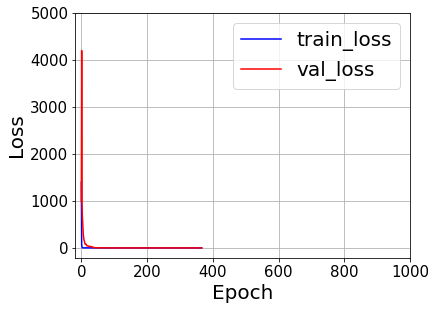

In [17]:
### Plot the Loss graph

if train_mode == True:
    plt.subplots(figsize=(6,4.5))
    plt.plot(history.history['loss'],'b-',label='train_loss')
    plt.plot(history.history['val_loss'],'b-',label='val_loss',color='r')

    plt.legend(prop={'size': 20})

    plt.xlabel("Epoch", fontdict={'size': 20})
    plt.ylabel("Loss", fontdict={'size': 20})

    plt.xticks((0, 200, 400, 600, 800, 1000),fontsize=15)
    plt.yticks((0, 1000, 2000, 3000, 4000, 5000),fontsize=15)

    plt.grid(True)
    plt.show()

In [15]:
### Print the prediction results

test_losses = []
p_result_0 = []

# Load Model & Make Results
model.load_weights(model_save_dir)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())

test_losses = model.evaluate(x_test_shuffled, y_test_shuffled, verbose=0)
p_result_0 = model.predict(x_test_shuffled)

p_result_0

array([[44.378338],
       [59.744167],
       [40.105827],
       ...,
       [43.67832 ],
       [59.600407],
       [46.28898 ]], dtype=float32)

In [16]:
### print RMSE and R2-score

rmse_0 = round(mean_squared_error(y_test_shuffled, p_result_0, squared=False), 4)
r2_0 = round(r2_score(y_test_shuffled, p_result_0), 4)

print(f"RMSE : {rmse_0}")
print(f"r2_score : {r2_0}")

RMSE : 1.4421
r2_score : 0.9521
